In [0]:
import math
import pandas as pd
import numpy as np
import calendar
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime

from matplotlib.dates import DateFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

# Downloading the Dataset


Google Colab runs remotely on a Linux server. It has numerous Python libraries installed by default, and uses the same underlying terminal (Bash) as Mac OS X. We can execute terminal commands from Google Colab notebooks by starting the statement with a '!' 

This allows us to download data, clone repositories on GitHub, and much more. In this example, we use the wget command to download our data to a file called `bikeshare_train.csv`. We can check the files tab in the expandable side menu after running the cell to check the data visually. 

For this course, you aren't expected to do anything sophisticated with the command line. If you *are* interested in learning more about how to use linux commands, the wget command, and how to use wget with files hosted on google drive, you can check out these resources. You may notice that the documentation is very long, but don't be afraid because you don't need to worry about 99% of the stuff in there! I've also tagged on a useful cheatsheet so you can format these markdown boxes easily.

*  [common linux commands](https://www.dummies.com/computers/operating-systems/linux/common-linux-commands/)
*  [wget documentation](https://www.computerhope.com/unix/wget.htm)
*  [using wget with google drive](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)
*  [nifty markdown cheat sheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)

It can be difficult to get used to linux commands at first, but they can definitely help accelerate and scale your workflow in the long run.


In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ' -O bikeshare_train.csv

--2020-01-23 01:00:09--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ
Resolving docs.google.com (docs.google.com)... 74.125.142.113, 74.125.142.102, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a4m7c0kgmrcuab7re4vsmd633jq46rd9/1579737600000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download [following]
--2020-01-23 01:00:10--  https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a4m7c0kgmrcuab7re4vsmd633jq46rd9/1579737600000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download
Resolving doc-0s-5c-docs.googleusercontent.com (doc-0s-5c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to do

# Bikeshare Data: Exploratory Data Analysis

This weekend's examples will mostly be drawn from the Capital Bikeshare dataset from Washington, DC over 2 years. Each row of the dataset represents one hour of that time period, gives features about the weather including temperature, humidity, and windspeed, then includes rider activity as a variable to predict (total number of trips that were initiated in that hour).

In [0]:
bikeshare = pd.read_csv("bikeshare_train.csv") 
bikeshare.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Preprocessing

We have two main tasks to complete when cleaning up this data and making it ready for machine learning. 

### 1. Date/Time Features
The first is converting the timestamp to individual features for things like the day of week, hour, and month. We also want a matplotlib-compatible column for timestamps to be plotted in our graphs.

One problem with the "month" variable in a timestamp is that it's numeric. A `12` value is as far away as possible from a `1` value, but in practice they're actually very similar! To fix this, for months and weekdays we create additional variables (using the `calendar` library) to create nominal string variables.

In [0]:
bikeshare["date_objs"] = bikeshare["datetime"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [0]:
bikeshare["hour"] = bikeshare["date_objs"].apply(lambda x: x.hour)
bikeshare["day"] = bikeshare["date_objs"].apply(lambda x: x.day)
bikeshare["month"] = bikeshare["date_objs"].apply(lambda x: x.month)
bikeshare["year"] = bikeshare["date_objs"].apply(lambda x: x.year)
bikeshare["weekday"] = bikeshare["date_objs"].apply(lambda x: x.weekday())
bikeshare["plot_time"] = bikeshare["datetime"].apply(dates.datestr2num)

bikeshare["month_str"] = bikeshare["month"].apply(lambda x: calendar.month_name[x])
bikeshare["weekday_str"] = bikeshare["weekday"].apply(lambda x: calendar.day_name[x])

In [0]:
bikeshare.loc[:, ["weekday", "weekday_str"]]

,weekday,weekday_str
0,5,Saturday
1,5,Saturday
2,5,Saturday
3,5,Saturday
4,5,Saturday
...,...,...
10881,2,Wednesday
10882,2,Wednesday
10883,2,Wednesday
10884,2,Wednesday


### 2. Prediction Variable

Next, we want to convert this data into having a binary prediction variable, based on whether it will be a high-activity or low-activity day. For simplicity's sake we will treat the median as the dividing line for these labels.

In [0]:
bikeshare["count"].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [0]:
bikeshare["high_traffic"] = bikeshare["count"] > 145
bikeshare.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False


## Sanity Checks

First we'll do some evaluation to make sure that the dataset we're working with makes sense. If we do some digging we find that some preprocessing has already been done - for instance, in the dataset that was released to the public, instead of giving actual values for features like temperature and wind speed, the values were normalized to a preset range (0-40 in the case of temperature).

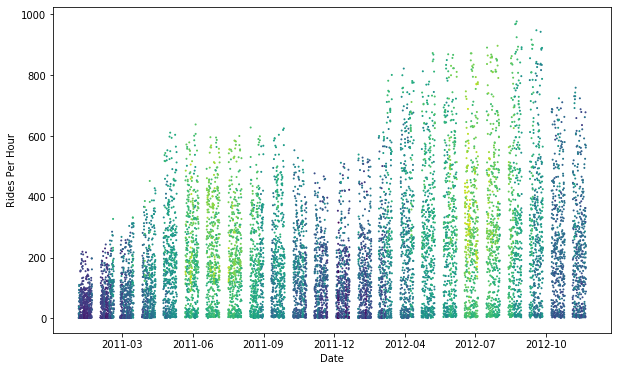

In [0]:
plt.figure(figsize=(10,6))
plt.scatter(bikeshare["plot_time"], bikeshare["count"], s=1, c=bikeshare["temp"])
plt.xlabel("Date")
plt.ylabel("Rides Per Hour")
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

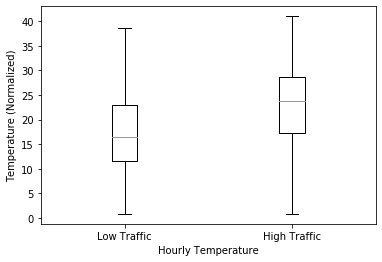

In [0]:
bikeshare_lows = bikeshare.loc[bikeshare["high_traffic"] == False]
bikeshare_highs = bikeshare.loc[bikeshare["high_traffic"] == True]

plt.boxplot([bikeshare_lows["temp"], bikeshare_highs["temp"]])
plt.xticks([1,2], ["Low Traffic", "High Traffic"])
plt.xlabel("Hourly Temperature")
plt.ylabel("Temperature (Normalized)")
plt.show()

Let's make a quick convenience function to be able to plot differences in values for a variety of different possible features.

2


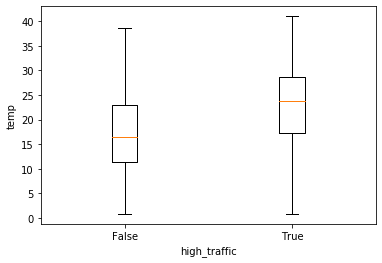

In [0]:
def boxplot_values(df, target_column, feature_column):
    vals = df[feature_column].unique()
    subsets = []
    for v in vals:
        subsets.append(df.loc[df[feature_column] == v][target_column])
    print(len(subsets))
    plt.boxplot(subsets)
    plt.xticks(np.arange(1, len(vals)+1), vals)
    plt.xlabel(feature_column)
    plt.ylabel(target_column)
boxplot_values(bikeshare, "temp", "high_traffic")

12


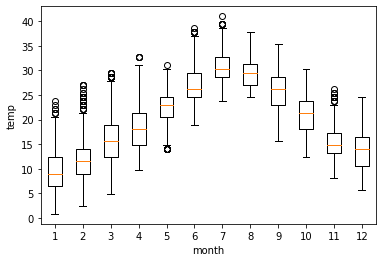

In [0]:
boxplot_values(bikeshare, "temp", "month")

12


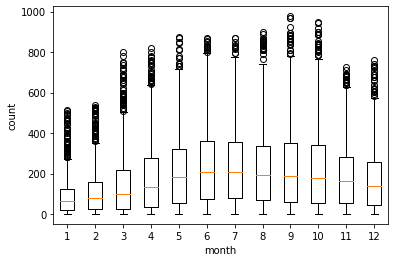

In [0]:
boxplot_values(bikeshare, "count", "month")

7


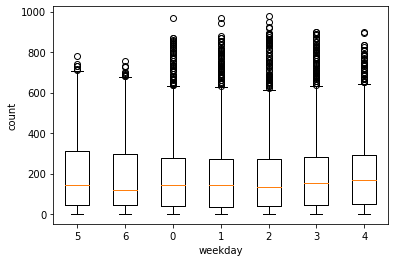

In [0]:
boxplot_values(bikeshare, "count", "weekday")

## Nominalizing the "weather" variable

The dataset documentation gives us the following descriptions of the `weather` variable:

   - 1: Clear or partly cloudy
   - 2: Misty, cloudy, overcast
   - 3: Light snow or rain, thunderstorms
   - 4: Heavy snow, heavy rain thunderstorms
   
These are probably better treated as labeled variables than numbers. Additionally, when we look at our training data, we see that the distribution is basically missing the fourth value (were there no heavy snows in two years in Washington? We don't know). As a result, let's create a normalized, nominal variable that is a little more intuitive.

In [0]:
bikeshare["weather"].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [0]:
def weather_norm(x):
    if x == 1:
        return "clear"
    if x == 2:
        return "overcast"
    if x > 2:
        return "gross"
    
bikeshare["weather_norm"] = bikeshare["weather"].apply(weather_norm)
bikeshare["weather_norm"].value_counts()

clear       7192
overcast    2834
gross        860
Name: weather_norm, dtype: int64

3


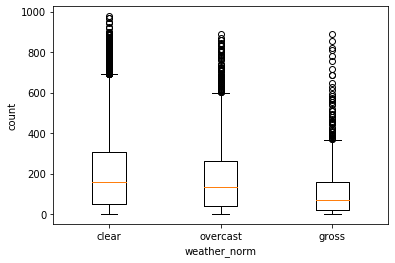

In [0]:
boxplot_values(bikeshare, "count", "weather_norm")

# Building a decision tree by hand

A [Decision Tree](https://medium.com/greyatom/decision-trees-a-simple-way-to-visualize-a-decision-dc506a403aeb) is a flowchart-like structure in which each node represents a "test" on the input and each edge represents the result of the previous test. By following the tree, we can perform classification tasks on a dataset. 

![alt text](https://miro.medium.com/max/301/0*QctkHiOX2G2pvfD_.jpg)

It's actually quite possible for us to build up a decision tree entirely manually - after all, they are only a series of if/then statements. Let's see how we can do if we just try to build one based on intuition alone.

How would we do that? One way is to first try to build a tree based on guessing.

## Decision tree based on guessing

In [0]:
def manual_decision_tree(row):
    if row["weather_norm"] == "clear":
        if row["month"] > 3:
            if row["month"] < 12:
                return True
            else:
                return False
        else:
            return False
    elif row["month"] > 5:
        if row["month"] < 10:
            return True
        else:
            return False
    else:
        return False

bikeshare["manual_coding"] = bikeshare.apply(manual_decision_tree, axis=1)
print(bikeshare["manual_coding"].value_counts())

predictions = bikeshare["manual_coding"]
actual = bikeshare["high_traffic"]

manual_accuracy = 100*accuracy_score(predictions, actual)
print(f"Manual coding got {manual_accuracy:.1f}% accuracy.")

True     5938
False    4948
Name: manual_coding, dtype: int64
Manual coding got 61.5% accuracy.


## Decision tree by carefully picking a feature


But we're mostly shooting in the dark here. It would be really nice to be able to test individual features to see which ones will be helpful for us.

In [0]:
def evaluate_split_on_feature(df, column):
    for label in df[column].unique():
        matched_rows = df.loc[df[column] == label]
        counts = matched_rows["high_traffic"].value_counts()
        counts = 100 * counts / len(matched_rows)
        print(label)
        print(counts)
        print("-----")

evaluate_split_on_feature(bikeshare, "weather_norm")

clear
True     53.225806
False    46.774194
Name: high_traffic, dtype: float64
-----
overcast
False    52.081863
True     47.918137
Name: high_traffic, dtype: float64
-----
gross
False    71.162791
True     28.837209
Name: high_traffic, dtype: float64
-----


In [0]:
evaluate_split_on_feature(bikeshare, "hour")

0
False    94.505495
True      5.494505
Name: high_traffic, dtype: float64
-----
1
False    99.339207
True      0.660793
Name: high_traffic, dtype: float64
-----
2
False    100.0
Name: high_traffic, dtype: float64
-----
3
False    100.0
Name: high_traffic, dtype: float64
-----
4
False    100.0
Name: high_traffic, dtype: float64
-----
5
False    100.0
Name: high_traffic, dtype: float64
-----
6
False    88.351648
True     11.648352
Name: high_traffic, dtype: float64
-----
7
True     56.483516
False    43.516484
Name: high_traffic, dtype: float64
-----
8
True     73.406593
False    26.593407
Name: high_traffic, dtype: float64
-----
9
True     78.241758
False    21.758242
Name: high_traffic, dtype: float64
-----
10
True     51.648352
False    48.351648
Name: high_traffic, dtype: float64
-----
11
True     64.835165
False    35.164835
Name: high_traffic, dtype: float64
-----
12
True     78.72807
False    21.27193
Name: high_traffic, dtype: float64
-----
13
True     76.973684
False    23.0263

After looking at multiple features to see which one looks like it's most effective at splitting the data, we can try to build a tree based on the best feature we found (hour), and see how we do.

In [0]:
def night_hours_tree(row):
    if row["hour"] < 6:
        return False
    elif row["hour"] == 23:
        return False
    else:
        return True

bikeshare["day_coding"] = bikeshare.apply(night_hours_tree, axis=1)
print(bikeshare["day_coding"].value_counts())

predictions = bikeshare["day_coding"]
actual = bikeshare["high_traffic"]

manual_accuracy = 100*accuracy_score(predictions, actual)
print(f"Manual coding got {manual_accuracy:.1f}% accuracy.")

True     7746
False    3140
Name: day_coding, dtype: int64
Manual coding got 77.0% accuracy.


In [0]:
daytime_df = bikeshare.loc[bikeshare.day_coding == True]
evaluate_split_on_feature(daytime_df, "weather_norm")

clear
True     73.365949
False    26.634051
Name: high_traffic, dtype: float64
-----
overcast
True     66.56746
False    33.43254
Name: high_traffic, dtype: float64
-----
gross
False    60.16129
True     39.83871
Name: high_traffic, dtype: float64
-----


## Two Layer Decision Tree

In [0]:
def two_layer_tree(row):
    daytime = night_hours_tree(row)
    if daytime:
        if row["weather_norm"] == "gross":
            return False
        else:
            return True
    else:
        return False
    

bikeshare["two_level_tree"] = bikeshare.apply(two_layer_tree, axis=1)
print(bikeshare["two_level_tree"].value_counts())

predictions = bikeshare["two_level_tree"]
actual = bikeshare["high_traffic"]

manual_accuracy = 100*accuracy_score(predictions, actual)
print(f"Manual coding got {manual_accuracy:.1f}% accuracy.")

True     7126
False    3760
Name: two_level_tree, dtype: int64
Manual coding got 78.2% accuracy.


## Conclusions so far

So with our fully manual attempts at building up logic into our bikeshare classifier, we've gotten the following results:

   - Total guessing: 61.5%
   - Choosing one highly relevant feature: 77.0%
   - Building a two-layer tree: 78.2%
   
This is starting to look like an extremely tedious process to get any better results. For each branch of our tree we'd need to keep doing additional tests, figuring out which features are informative and which are not.

# Information Theory

We'll start by showing how you can calculate entropy for a single variable that's uniformly distributed in our dataset: the day of the week that a data instance appeared in.

## Calculating Entropy

Entropy is a way that we can measure how surprising (or equivalently, how random) a random variable is. A random variable with low entropy is more predictable than a random variable with high entropy. Entropy is denoted by H(X) and is measured in bits. 

$$\ H(X)=\sum_{x \in X}{p(x)log(p(x))}$$

1 bit of entropy is equivalent to the randomness of a flip of a fair coin (50% heads/50% tails). The probability distribution on any set with the highest entropy is the uniform distribution as there is no way to guess the outcome better than randomly guessing. 

In [0]:
weekday_counts = bikeshare.groupby("weather_norm").size()

# Calculate probabilities for each possible label
probabilities = {}
for ix in weekday_counts.index:
    value = weekday_counts[ix]
    probability = value / len(bikeshare)
    probabilities[ix] = probability
    print(f"Label {ix} probability {100*probability:.1f}%")

# Get the entropy of the weather    
summation = 0
for weekday in probabilities.keys():
    probability = probabilities[weekday]
    summation += probability * math.log2(probability)
    
summation = -summation
print(f"{summation:.3f}")

Label clear probability 66.1%
Label gross probability 7.9%
Label overcast probability 26.0%
1.190


Based on this, we can then write a more generic function that does these same calculations for any column we're interested in.

In [0]:
def calculate_probabilities(df, column_name):
    column_counts = df.groupby(column_name).size()
    probabilities = {}
    for ix in column_counts.index:
        value = column_counts[ix]
        probability = value / len(df)
        probabilities[ix] = probability
    return probabilities

def calculate_entropy(df, column_name):
    # Calculate probabilities for each possible label
    probabilities = calculate_probabilities(df, column_name)

    # Sum expected values of each possible label
    summation = 0
    for value in probabilities.keys():
        probability = probabilities[value]
        summation += probability * math.log2(probability)
    summation = -summation
    return summation
    
    
def test_entropy_function(function_to_test):
    values = ["weekday", "high_traffic", "hour", "datetime", "count"]
    for column in values:
        print(f"Entropy from {column}: {function_to_test(bikeshare, column):.3f}")

test_entropy_function(calculate_entropy)

Entropy from weekday: 2.807
Entropy from high_traffic: 1.000
Entropy from hour: 4.585
Entropy from datetime: 13.410
Entropy from count: 8.877


Of course, this type of calculation is almost never something you'll want to implement yourself. Scipy has a function built-in to do the same thing for you.

In [0]:
def entropy_using_scipy(df, column_name):
    probabilities = calculate_probabilities(df, column_name)
    clean_probabilities = list(probabilities.values())
    return stats.entropy(clean_probabilities, base=2)

test_entropy_function(entropy_using_scipy)

Entropy from weekday: 2.807
Entropy from high_traffic: 1.000
Entropy from hour: 4.585
Entropy from datetime: 13.410
Entropy from count: 8.877


## Calculating Information Gain

Also known as mutual information, information gain gets its name because it quanitifes how much information about Y (in bits) we gain by knowing the value of X. We write mutual information as I(Y;X).

$$\ I(Y;X)=H(Y) - H(Y|X) $$

The value H(Y|X) is called the conditional entropy of Y conditioned on X. It quantifies how surprising Y still is even after we know X.

$$\ H(Y|X) = \sum_{x \in X, y \in Y} p(x,y) log\frac{p(x,y)}{p(x)}$$

Notice that, the sum of the amount of information about Y we gain from knowing X and the entropy of Y conditioned on X is equal to the entropy of Y. This makes sense since we should not be magically gaining or losing information somewhere. 

In [0]:
def conditional_entropy(df, col_a, col_b):

    a_probs = calculate_probabilities(df, col_a)
    b_probs = calculate_probabilities(df, col_b)

    joint_probs = {}
    for a_val in df[col_a].unique():
        joint_probs[a_val] = {}
        for b_val in df[col_b].unique():
            a_matches = df.loc[df[col_a] == a_val]
            both_matches = a_matches.loc[a_matches[col_b] == b_val]
            p_both = len(both_matches) / len(df)
            joint_probs[a_val][b_val] = p_both
            
            
    sum_conditional = 0
    for b_val in df[col_b].unique():
        p_b = b_probs[b_val]
        
        sum_a = 0
        for a_val in df[col_a].unique():
            p_both = joint_probs[a_val][b_val]
            p_cond = 0
            if p_b > 0 and p_both > 0:
                p_cond = p_both / p_b
                sum_a += p_cond * math.log2(p_cond)
            
        sum_a = -sum_a
        sum_conditional += (p_b * sum_a)
    
    return sum_conditional
    
    
def info_gain(df, col_a, col_b):
    print(f"Mutual Information between {col_a} and {col_b}:")
    initial_entropy = entropy_using_scipy(df, col_a)
    print(f"Initial: {initial_entropy:.3f}")
    conditional = conditional_entropy(df, col_a, col_b)
    gain = initial_entropy - conditional
    print(f"Conditional: {conditional:.3f} Gain: {gain:.3f}")
    print("----")

info_gain(bikeshare, "hour", "month")
info_gain(bikeshare, "high_traffic", "month")
info_gain(bikeshare, "high_traffic", "hour")
info_gain(bikeshare, "high_traffic", "weather_norm")

Mutual Information between hour and month:
Initial: 4.585
Conditional: 4.585 Gain: 0.000
----
Mutual Information between high_traffic and month:
Initial: 1.000
Conditional: 0.944 Gain: 0.056
----
Mutual Information between high_traffic and hour:
Initial: 1.000
Conditional: 0.586 Gain: 0.414
----
Mutual Information between high_traffic and weather_norm:
Initial: 1.000
Conditional: 0.987 Gain: 0.013
----


In [0]:
# This will produce a value that's close, 
# but not quite, the same as what we calculated above
def info_gain_using_scipy(df, column_name, conditional_column):
    gain = mutual_info_score(df[column_name], df[conditional_column])
    print(gain)
    
info_gain_using_scipy(bikeshare, "hour", "month")

0.00022588753695368217


In [0]:
# Notice that using the scipy version is over 200x faster
%time info_gain(bikeshare, "hour", "month")
print('\n')
%time info_gain_using_scipy(bikeshare, "hour", "month")

Mutual Information between hour and month:
Initial: 4.585
Conditional: 4.585 Gain: 0.000
----
CPU times: user 606 ms, sys: 2.03 ms, total: 608 ms
Wall time: 613 ms


0.00022588753695368217
CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 2.81 ms


# Machine Learning

We can build a decision tree classifier automatically by creating splits based on the mutual information between some feature in our input and our output of interest. 

First off: Define a base case, datasets where there is no reason to build a tree
- All the examples in the dataset have the same class label
- There are not enough examples available to calculate statistics
- I(Y;X) is almost zero for every possible feature X you have access to

If none of these criteria are met, that means:
- There’s enough data to make a split in the tree
- There’s at least one feature that’ll make that split worthwhile.
- So split the data (into leaf nodes) and then try again on

Now we're ready to build our first classifier, a decision tree based on weather features. Below is the simplest code that will get us to a complete trained model based on data.


## Building decision trees automatically

Scikit-learn comes with one implementation of decision trees that you can call in a single line of code. Here we're going to use entropy as our criterion for whether to split a leaf of a tree, though there are other equations you can use instead.

In [0]:
weather_features = ["weather_norm", "temp", "atemp", "humidity", "windspeed"]

X = bikeshare.loc[:, weather_features]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]

model = DecisionTreeClassifier(criterion="entropy").fit(X, y)
y_pred = model.predict(X)

y_matches = (y_pred == y)
accuracy = 100 * y_matches.sum() / len(y)
print(f"Decision tree model achieved {accuracy:.1f}% accuracy on training data.")

Decision tree model achieved 89.6% accuracy on training data.


## Evaluating which feature sets are valuable

We have already improved drastically on our manually created tree, in only a few lines of code and with no manual fiddling. Can we do even better by optimizing which features are included?

In [0]:
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather_norm", "temp", "atemp", "humidity", "windspeed"]

feature_sets = {
    "date only": date_features,
    "time only": time_features,
    "date and time": date_features + time_features,
    "weather only": weather_features,
    "all features": date_features + time_features + weather_features
}

best = 0
best_name = None

for set_name, feature_set in feature_sets.items():

    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X, y)
    y_pred = model.predict(X)

    y_matches = (y_pred == y)
    accuracy = 100*accuracy_score(y, y_pred)
    if accuracy >= best:
        best = accuracy
        best_name = set_name
        

    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Feature set: {set_name}")
    print(f"   Accuracy: {accuracy:.1f}%")
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    

print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Feature set: date only
   Accuracy: 65.9%
   Tree contains 450 leaves
Feature set: time only
   Accuracy: 80.8%
   Tree contains 21 leaves
Feature set: date and time
   Accuracy: 100.0%
   Tree contains 1062 leaves
Feature set: weather only
   Accuracy: 89.6%
   Tree contains 3429 leaves
Feature set: all features
   Accuracy: 100.0%
   Tree contains 826 leaves
Best feature set is: all features 
With: 100.0% accuracy.


### Presenting Feature Sets Results

With the loop above, we're able to quickly see the following results:

| Date | Time | Weather | Accuracy  | Tree Size |
|------|------|---------|-----------|-----------|
| X    |      |         | 65.9%     | 450       |
|      | X    |         | 80.8%     | 21        |
|      |      | X       | 100.0%    | 1062      |
| X    | X    |         | 89.6%     | 3429      |
| X    | X    | X       | **100.0%** | **826**  |


## Constraining Tree Size
Next question for us is, how do these results change as we constrain our tree to be smaller and more interpretable?

In [0]:
def evaluate_tree(min_split, noisy=True):
    feature_set = feature_sets["all features"]
    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    model = DecisionTreeClassifier(criterion="entropy", min_samples_split=min_split, random_state=123).fit(X, y)
    y_pred = model.predict(X)

    y_matches = (y_pred == y)
    accuracy = 100*accuracy_score(y, y_pred)
    # Bookkeeping and printing for the reader (not part of the core loop)
    if noisy:
        print(f"Feature set: {set_name}")
        print(f"   Accuracy: {accuracy:.1f}%")
        print(f"   Tree contains {model.get_n_leaves()} leaves")
    return accuracy
    
for minimum in [2, 5, 10, 50, 100]:
    evaluate_tree(minimum)


Feature set: all features
   Accuracy: 100.0%
   Tree contains 826 leaves
Feature set: all features
   Accuracy: 98.6%
   Tree contains 678 leaves
Feature set: all features
   Accuracy: 97.0%
   Tree contains 506 leaves
Feature set: all features
   Accuracy: 92.6%
   Tree contains 194 leaves
Feature set: all features
   Accuracy: 90.4%
   Tree contains 120 leaves


Notice how, as we increase the number of samples required to make a split, our accuracy goes down and the size of our tree also goes down. Let's see how this sort of trend progresses at a larger scale.

In [0]:
# Compute the accuracies of the tree for a wide range of minimum number of samples
# necessary for a split 
accuracies = []
for i in range(2,1000,10):
    accuracies.append(evaluate_tree(i, noisy=False))

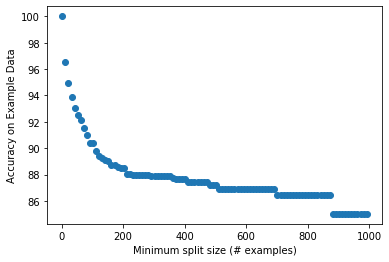

In [0]:
plt.scatter(range(2,1000,10), accuracies)
plt.ylabel("Accuracy on Example Data")
plt.xlabel("Minimum split size (# examples)")
plt.show()

# Tomorrow

Tomorrow, we'll start with discussing why this kind of performance chart might have significant problems, and not represent the real-world performance of the tree. For now, enjoy your Friday!